In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT
from dstft.loss import kurtosis_loss, entropy_loss
from dstft.optim import scale_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

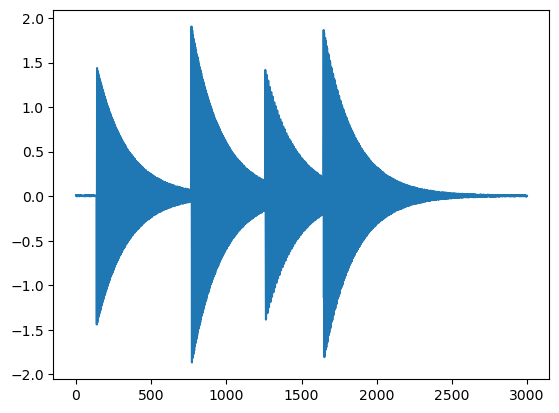

In [2]:
fs = 1e3
t = torch.arange(0, 3, 1/fs)
L = t.shape[0]
#index_impulse = torch.randint(0, L, size = (5,))
mark_list = [138, 768, 1259, 1647]
index_impulse = torch.tensor(mark_list).long()

alpha = 5
f =  torch.ones_like(t)
f[:768] = 250 * f[:768]
f[768:1259] = 200 * f[768:1259]
f[1259:1647] = 100 * f[1259:1647]
f[1647:] = 300 * f[1647:]
x =  torch.sin(torch.cumsum(2*pi*f, dim=0)/fs) 
y = torch.zeros_like(x)
y[index_impulse] = 1 + torch.rand(index_impulse.shape)
z = torch.exp(-t*alpha)
z1 = torch.fft.ifft(torch.fft.fft(z)*torch.fft.fft(y))
x = x * z1.real + .01 * torch.rand(f.shape)
x = x[None, :].to(device)
plt.plot(x[0].cpu())


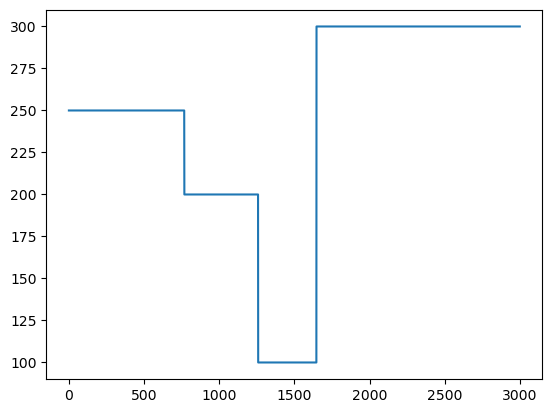

In [3]:
plt.figure()
plt.plot(f)
plt.show()

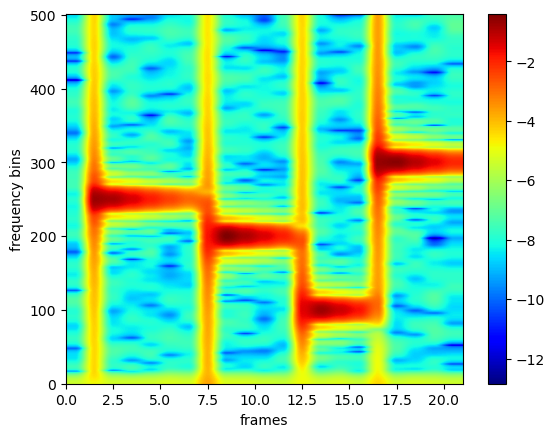

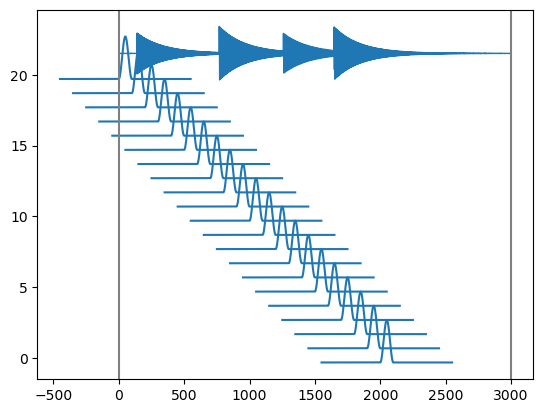

In [4]:
dstft = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p='t', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

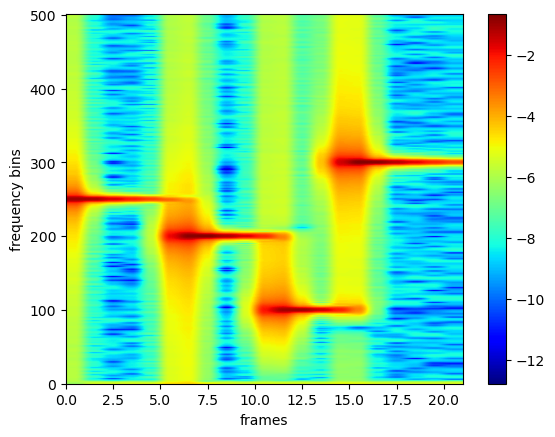

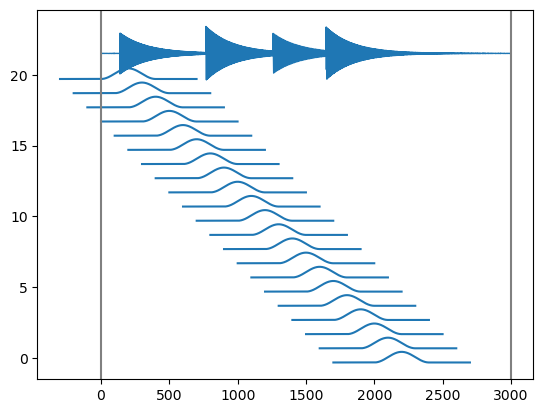

In [5]:
dstft = FDSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p='t', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

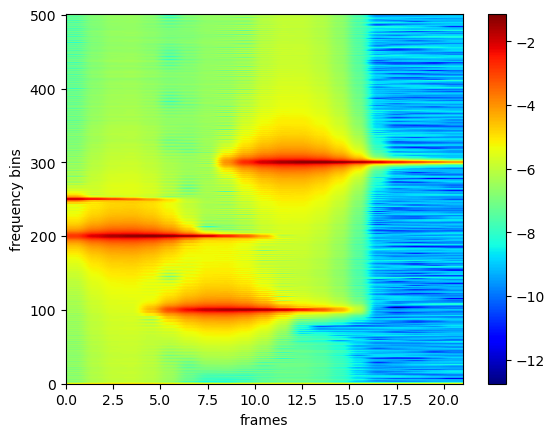

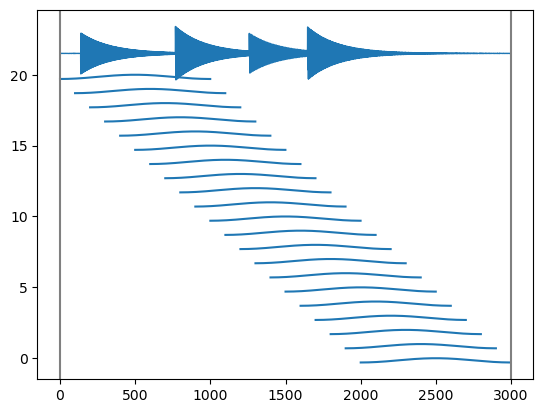

In [6]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True)

time-varying hop length

Epoch 00728: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00828: reducing learning rate of group 0 to 1.0000e-02.
827


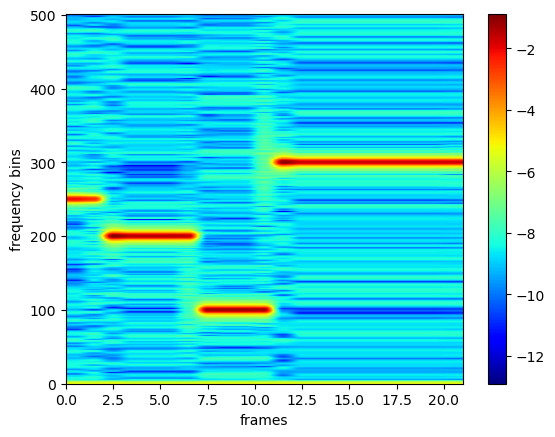

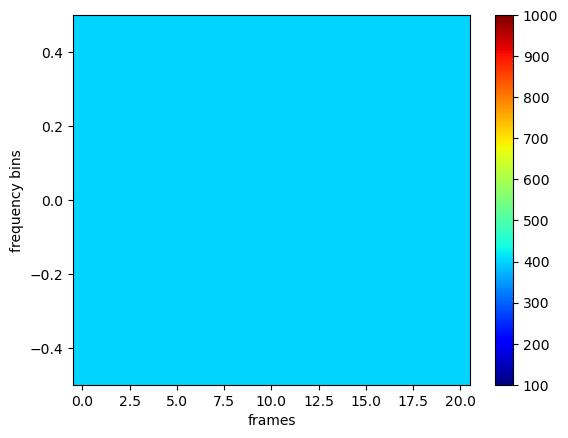

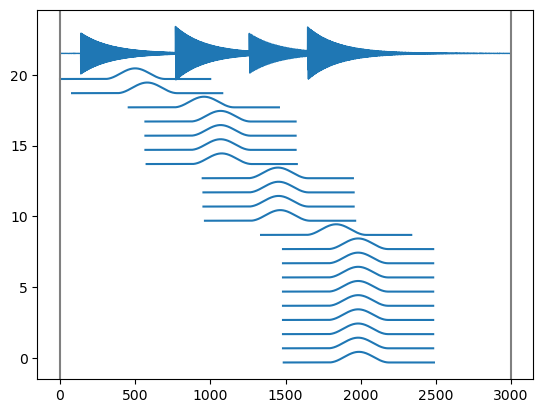

In [7]:
dstft = FDSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Time-varying window and hop length

Epoch 01530: reducing learning rate of group 0 to 1.0000e-01.
Epoch 01661: reducing learning rate of group 0 to 1.0000e-02.
1660


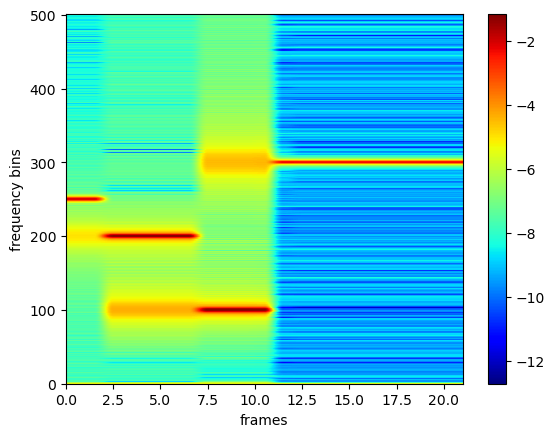

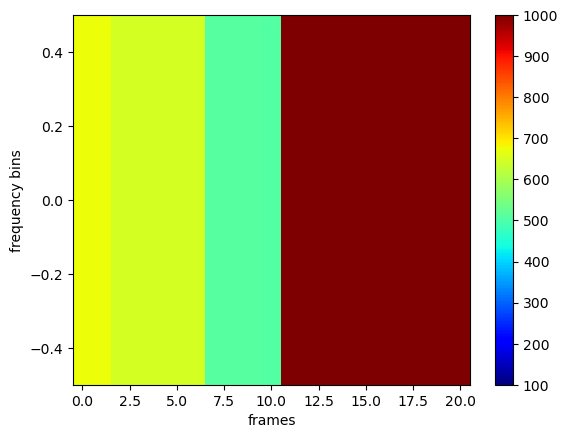

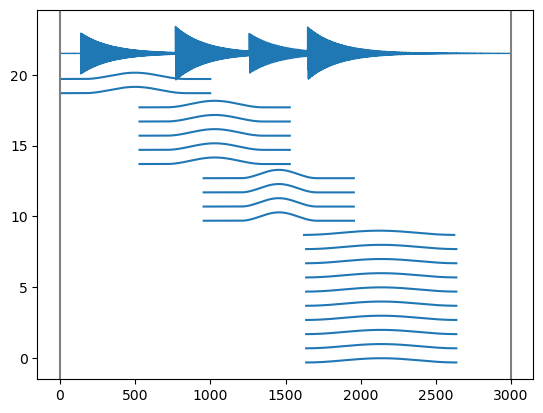

In [8]:
dstft = FDSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Multi objective optimization

In [10]:
dstft = DSTFT(x, win_length=400, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=10, first_frame=True)
params = [ {'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(loss1+loss2)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True)

RuntimeError: The expanded size of the tensor (1000) must match the existing size (501) at non-singleton dimension 0.  Target sizes: [1000, 21].  Tensor sizes: [501, 21]